# Baseline Oridinarey Linear Regression Model for Benchmarking
## For Public Health dataset
The notebook reads the requested feautres, normalzies them, fits the model and saves the test results to a csv file.
<br>
model_compare/res_OLS_public_health.csv
<br>
Created by: Karol Luszczek

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

sys.path.append(os.path.abspath('../../src/data'))
from extract_for_model import extract_time_series
from extract_for_model import scale_time_series_single


from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
# Import required paths to input files
# Change the file to import if needed
from data_links import health_pub_IS as input_IS
from data_links import health_pub_BS as input_BS

In [3]:
###
### PARAMETERS TO SET BY USER. DONTT EDIT THE VARIABLES NAMES. EDIT PATHS AND LISTS OF FEATURES IF NEEDED
### IF TARGET IS NOT IQ_TOTAL_REV OTHER CELLS NEEDS TO BE EDITED TOO
##
#
# Path to income statements and a list of requested features from income statements
source_IS   = input_IS
features_IS = ['IQ_EBIT','IQ_TOTAL_OTHER_OPER','IQ_EARNING_CO','IQ_TOTAL_REV']
#
# Path to balance sheets and a list of requested features from income statements
features_BS =  ['IQ_AR','IQ_RE','IQ_TOTAL_ASSETS','IQ_TOTAL_CL','IQ_TOTAL_EQUITY','IQ_TOTAL_LIAB_EQUITY']
source_BS   = input_BS
#
# Desirted path for summary of test results
output_path = 'model_compare/res_OLS_public_health.csv'
# 
# Target variable (to be predicted)
target = 'IQ_TOTAL_REV'
#
# List of predictors, should include appendicies from data shifiting
predictors  =['IQ_TOTAL_REV-1','IQ_TOTAL_REV+0']

In [4]:
### Create output folder if needed
if (len(output_path.split('/')) > 1):
    out_folder = output_path.split('/')[:-1]
    out_folder = '/'.join(out_folder)
    if not (os.path.isdir(out_folder)):
        os.mkdir(out_folder)

In [5]:
def plot_actual_vs_predict(y_test,y_pred,target):
    """Prints the actual versus predicted values"""
    plt.figure(figsize=(6, 6))
    limit = max(np.absolute(y_test).max(),np.absolute(y_test).max())
    plt.xlim(0, limit)
    plt.ylim(0, limit)
    plt.scatter(y_pred,y_test, s=10)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.plot([-limit,limit], [-limit,limit], ls="--", c=".3")
    plt.title('Actual vs Predicted REVENUE')
    plt.grid()
    plt.show()
    

In [6]:
def correct_class(y_pred,y_test):
    """Function corrects percentage of wrongly classified growth"""
    wrong = 0
    for y1,y2 in zip(y_pred,y_test):
        test = y1*y2
        if test < 0:
            wrong +=1
    total = len(y_pred)
    print("Percentage of incorrectly classified growth %.2f %%" %(wrong/total*100))
                

In [7]:
def OLS(features,target,train_df,test_df,label):
    '''Create the OLS model with selected features'''
    X_train = np.array(train_df[features])
    y_train = np.array(train_df[target])
    X_train = sm.add_constant(X_train)

    X_test = np.array(test_df[features])
    X_test = sm.add_constant(X_test)
    y_test = np.array(test_df[target]) 

    olsmod = sm.OLS(y_train, X_train)
    olsres = olsmod.fit()
    print(label+str(features))
    print(olsres.summary())
    y_pred = olsres.predict(X_test)
    print("-----------------------------")
    print("MSE:"+str(mean_squared_error(y_test,y_pred)))
    print("MAE:"+str(mean_absolute_error(y_test,y_pred)))

    plot_actual_vs_predict(y_test,y_pred,target)
    correct_class(y_test,y_pred)

In [8]:
def OLS_norm(features,target,train_df,test_df,label):
    '''Create the OLS model with selected features'''
    '''Version for normalized features. Inverse transfrom applied at the end'''
    X_train = np.array(train_df[features])
    y_train = np.array(train_df[target])
    X_train = sm.add_constant(X_train)

    X_test = np.array(test_df[features])
    X_test = sm.add_constant(X_test)
    y_test = np.array(test_df[target]) 

    olsmod = sm.OLS(y_train, X_train)
    olsres = olsmod.fit()
    print(label+str(features))
    print(olsres.summary())
    y_pred = olsres.predict(X_test)
    print("-----------------------------")

    y_test = dict_scalers[target].inverse_transform(y_test.reshape(-1, 1))
    y_pred = dict_scalers[target].inverse_transform(y_pred.reshape(-1, 1))
    print("MSE:"+str(mean_squared_error(y_test,y_pred)))
    plot_actual_vs_predict(y_test,y_pred,target)
    correct_class(y_test,y_pred)
    return olsres

In [9]:
# Read selected data from the INTERIM file
# Read from income statements
#
# NOTE: more features than required in the model are read from interim files.
# At the time it wasn't clear which features will work best. 
# Other test models were removed from the notebook for clarity.
#
IS_train, IS_test = extract_time_series(input_path = source_IS,\
                                          features = features_IS,
                                             steps = 2,\
                                          year_min = 2012,\
                                          no_shift = False,\
                                              date = True,\
                                         quarterly = True)

# Read from Balance Sheets
BS_train, BS_test = extract_time_series(input_path = source_BS,\
                                          features = features_BS,
                                             steps = 2,\
                                          year_min = 2012,\
                                          no_shift = False,\
                                              date = True,\
                                         quarterly = True)
#
x = IS_train.pop('year')
x = IS_train.pop('quarter')
x = IS_test.pop('year')
x = IS_test.pop('quarter')
#
x = BS_train.pop('year')
x = BS_train.pop('quarter')
x = BS_test.pop('year')
x = BS_test.pop('quarter')



train_df = IS_train.set_index(['company','date']).join(BS_train.set_index(['company','date']))
test_df  = IS_test.set_index(['company','date']).join(BS_test.set_index(['company','date']))

train_df = train_df.reset_index().dropna()
test_df  = test_df.reset_index().dropna()
data_set = pd.concat([train_df,test_df]).reset_index().dropna()

====  extract_time_series metric ====
Size of data read from the file: (14480, 8)
Size of RESHAPED data without NA: (12863, 20)
No of companies in RESHAPED data: 451
No of companies with more than 1 datapoint 444
TEST  set size: (444, 20)
TRAIN set size: (9480, 20)
TEST is 4% of all available datapoints
====  extract_time_series metric ====
Size of data read from the file: (14229, 10)
Size of RESHAPED data without NA: (10772, 28)
No of companies in RESHAPED data: 426
No of companies with more than 1 datapoint 421
TEST  set size: (421, 28)
TRAIN set size: (7926, 28)
TEST is 5% of all available datapoints


In [10]:
data_set

,index,company,date,IQ_EBIT-2,IQ_TOTAL_OTHER_OPER-2,IQ_EARNING_CO-2,IQ_TOTAL_REV-2,IQ_EBIT-1,IQ_TOTAL_OTHER_OPER-1,IQ_EARNING_CO-1,...,IQ_TOTAL_ASSETS+0,IQ_TOTAL_CL+0,IQ_TOTAL_EQUITY+0,IQ_TOTAL_LIAB_EQUITY+0,IQ_AR+1,IQ_RE+1,IQ_TOTAL_ASSETS+1,IQ_TOTAL_CL+1,IQ_TOTAL_EQUITY+1,IQ_TOTAL_LIAB_EQUITY+1
0,0,IQ1002655,2012-03-31,12.934622,62.501575,2.527583,161.822970,35.125885,63.480488,18.667982,...,962.646360,212.697360,325.804720,962.646360,76.969910,189.219440,934.596500,198.726320,334.367650,934.596500
1,1,IQ1002655,2012-06-30,35.125885,63.480488,18.667982,199.110670,11.234876,62.668380,2.630113,...,934.596500,198.726320,334.367650,934.596500,68.275696,188.991240,914.904800,243.163650,331.313000,914.904800
2,2,IQ1002655,2012-09-30,11.234876,62.668380,2.630113,163.544680,21.070630,60.829308,8.444901,...,914.904800,243.163650,331.313000,914.904800,90.135810,213.925610,948.177730,270.791100,348.941530,948.177730
3,3,IQ1002655,2012-12-31,21.070630,60.829308,8.444901,170.688190,11.332815,58.320946,2.456625,...,948.177730,270.791100,348.941530,948.177730,85.643140,218.641630,987.460450,267.472800,373.246670,987.460450
4,4,IQ1002655,2013-03-31,11.332815,58.320946,2.456625,150.537580,36.436398,64.244125,21.459324,...,987.460450,267.472800,373.246670,987.460450,93.860405,219.102260,940.878360,275.823240,338.318450,940.878360
5,5,IQ1002655,2013-06-30,36.436398,64.244125,21.459324,203.002080,5.194482,63.755608,-1.711243,...,940.878360,275.823240,338.318450,940.878360,76.421906,209.513640,920.879100,153.670580,322.810640,920.879100
6,6,IQ1002655,2013-09-30,5.194482,63.755608,-1.711243,159.790240,22.108147,64.776320,5.420122,...,920.879100,153.670580,322.810640,920.879100,86.195220,218.810350,944.700000,187.752900,316.789280,944.700000
7,7,IQ1002655,2013-12-31,22.108147,64.776320,5.420122,187.511260,2.505376,62.043373,-4.639585,...,944.700000,187.752900,316.789280,944.700000,74.704630,229.240830,948.731930,178.198580,333.150600,948.731930
8,8,IQ1002655,2014-03-31,2.505376,62.043373,-4.639585,148.623890,33.772476,-111.083570,11.772069,...,948.731930,178.198580,333.150600,948.731930,81.284320,223.180300,951.372700,185.260700,331.235500,951.372700
9,9,IQ1002655,2014-09-30,33.772476,-111.083570,11.772069,200.357930,6.552124,8.730378,8.254221,...,923.537540,160.891620,332.276150,923.537540,84.933290,235.191930,973.412900,189.533540,344.239400,973.412900


In [11]:
# Normalize numerical features only (don't send dates etc. to normalization)
# Normalization pararmeters are collected in the dictionary for later inverse transformation
#
features_to_norm = data_set.columns[4:]

norm_train_df = train_df.copy()
norm_test_df = test_df.copy()

dict_scalers = {}
for feature in features_to_norm:   
    norm_train_df, norm_test_df, param = scale_time_series_single(df_train = norm_train_df,\
                                                                  df_test  = norm_test_df,
                                                                 scalemode = 'minmax',
                                                                   feature = [feature])
    dict_scalers.update(param)
    
norm_train_df = norm_train_df.reset_index()
norm_test_df  = norm_test_df.reset_index()

In [12]:
# Reshape train_df and test_df to have single entry per company
#
#
test_df = pd.concat([test_df,train_df])
#
train_df = train_df.sort_values(by = 'company')
train_df = train_df.groupby('company').tail(1)
#
test_df = test_df.sort_values(by = 'company')
test_df = test_df.groupby('company').tail(1)

################################
norm_test_df = pd.concat([norm_test_df,norm_train_df])
#
norm_train_df = norm_train_df.sort_values(by = 'company')
norm_train_df = norm_train_df.groupby('company').tail(1)
#
norm_test_df = norm_test_df.sort_values(by = 'company')
norm_test_df = norm_test_df.groupby('company').tail(1)

In [13]:
train_df = train_df.dropna()
test_df = test_df.dropna()
norm_test_df = norm_test_df.dropna()
norm_test_df = norm_test_df.dropna()

In [14]:
norm_test_df

,index,company,date,IQ_EBIT-2,IQ_TOTAL_OTHER_OPER-2,IQ_EARNING_CO-2,IQ_TOTAL_REV-2,IQ_EBIT-1,IQ_TOTAL_OTHER_OPER-1,IQ_EARNING_CO-1,...,IQ_TOTAL_ASSETS+0,IQ_TOTAL_CL+0,IQ_TOTAL_EQUITY+0,IQ_TOTAL_LIAB_EQUITY+0,IQ_AR+1,IQ_RE+1,IQ_TOTAL_ASSETS+1,IQ_TOTAL_CL+1,IQ_TOTAL_EQUITY+1,IQ_TOTAL_LIAB_EQUITY+1
10,10,IQ1002655,2014-12-31,6.552124,0.045740,0.268865,0.014506,0.086180,0.045862,0.268370,...,0.008826,0.006584,0.030027,0.008826,0.008626,0.098309,0.008669,0.008051,0.030046,0.008669
29,29,IQ100410633,2013-06-30,-13.551497,0.047032,0.266751,0.000779,0.080806,0.047066,0.266784,...,0.000945,0.000995,0.025812,0.000945,0.001098,0.092248,0.000886,0.000976,0.025768,0.000886
54,54,IQ10158679,2013-03-31,0.800144,0.045638,0.268175,0.004011,0.083851,0.045833,0.268102,...,0.002149,0.002442,0.027290,0.002149,0.002213,0.097156,0.002201,0.002570,0.027317,0.002201
93,93,IQ10246536,2016-06-30,0.864262,0.044254,0.268166,0.000689,0.083800,0.044271,0.268146,...,0.000248,0.000738,0.025231,0.000248,0.001129,0.095250,0.000258,0.000776,0.025238,0.000258
103,103,IQ1029971,2012-06-30,9.500000,0.058600,0.268938,0.007983,0.085942,0.037363,0.269093,...,0.005366,0.002230,0.029090,0.005366,0.008008,0.097268,0.005325,0.002167,0.029037,0.005325
128,131,IQ103375,2012-12-31,525.331200,0.789073,0.303878,0.742311,0.222000,0.708295,0.305975,...,0.377463,0.369247,0.238043,0.377463,0.670928,0.264820,0.386813,0.404938,0.269815,0.386813
140,160,IQ1051103,2013-12-31,7.841448,0.050855,0.268615,0.006743,0.086355,0.049722,0.268827,...,0.003865,0.002129,0.028984,0.003865,0.004679,0.097310,0.003841,0.002086,0.028979,0.003841
6,7,IQ10524718,2018-09-30,4.256592,0.044261,0.268564,0.002641,0.084673,0.044263,0.268567,...,0.002271,0.001710,0.026945,0.002271,0.003603,0.095560,0.002291,0.001725,0.026960,0.002291
200,220,IQ107137171,2015-12-31,0.064383,0.044081,0.268119,0.000535,0.083684,0.044082,0.268119,...,0.000034,0.000016,0.025196,0.000034,0.000077,0.095265,0.000036,0.000011,0.025200,0.000036
215,250,IQ1072270,2016-12-31,40.112854,0.054745,0.270473,0.012219,0.087260,0.054817,0.269215,...,0.008069,0.005449,0.031929,0.008069,0.014038,0.097186,0.008935,0.007425,0.033725,0.008935


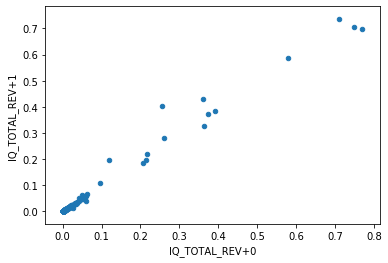

In [15]:
# Plots for visial inspection
ax1 = norm_train_df.plot.scatter(y=target+'+1', x=target+'+0')

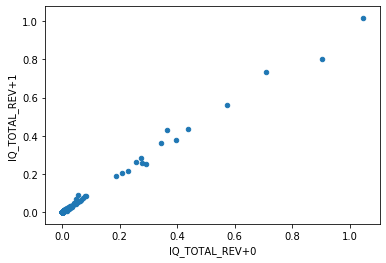

In [16]:
ax2 = norm_test_df.plot.scatter(y='IQ_TOTAL_REV+1', x='IQ_TOTAL_REV+0')

Model with normalization!['IQ_TOTAL_REV-1', 'IQ_TOTAL_REV+0']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                 1.301e+04
Date:                Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                        22:25:52   Log-Likelihood:                 1332.6
No. Observations:                 421   AIC:                            -2659.
Df Residuals:                     418   BIC:                            -2647.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

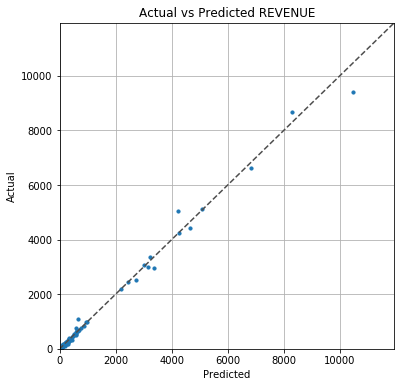

Percentage of incorrectly classified growth 0.24 %


In [17]:
# Create OLS model for normalized features
#
target_OLS = target+'+1'
label      = "Model with normalization!"
#
ols = OLS_norm(predictors,target_OLS,norm_train_df,norm_test_df,label)

In [18]:
norm_train_df = norm_train_df.set_index(['company','date'])
norm_test_df = norm_test_df.set_index(['company','date'])

In [19]:
# Make preidciton for test data
X_test = np.array(norm_test_df[predictors])
X_test = sm.add_constant(X_test)
y_test = np.array(norm_test_df[target_OLS])
#
y_pred = ols.predict(X_test)
y_test = dict_scalers[target_OLS].inverse_transform(y_test.reshape(-1, 1))
y_pred = dict_scalers[target_OLS].inverse_transform(y_pred.reshape(-1, 1))

In [20]:
# Collect test prediciton and targets for comparisons. Export to csv file
norm_test_df[target+'_target']=y_test
norm_test_df[target+'_OLS']=y_pred
res_OLS =norm_test_df[[target+'_target',target+'_OLS']]

In [21]:
res_OLS.to_csv(output_path)

In [22]:
#
# Showcasing the serialization discussed in Section 7.1 of the report.
# This notebook will do it with pickle. In OLS_base_soft_public.ipnyb this will be repeated with joblib package
#

In [23]:
import pickle

In [24]:
# Create output folder if needed
#
out_folder = 'exported_models'
if not (os.path.isdir(out_folder)):
    os.mkdir(out_folder)

In [25]:
# Pickle the model
#
model_file_name = 'exported_models/MODEL_OLS_base_health_public.sav'
pickle.dump(ols,open(model_file_name,'wb'))

In [26]:
# Load the pickled model and make prediction using the same test set
# Mind that data needs to be inversely transformed due to scaling
#
loaded_OLS = pickle.load(open(model_file_name,'rb'))
new_y_pred = loaded_OLS.predict(X_test)
new_y_pred = dict_scalers[target_OLS].inverse_transform(new_y_pred.reshape(-1, 1))

In [27]:
# Subtract new prediciton from the old. if the same sum shgould be zero
sum(new_y_pred - y_pred)

array([0.])